<a href="https://colab.research.google.com/github/whoami-Lory271/thesis-project/blob/main/LSTM_Linear_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbol legend

* B: batch size
* L: lookback window (aka input_size)


# Installations and imports


In [1]:
!pip install pytorch-lightning==2.0.1.post0 --quiet
!pip install einops==0.6.1 --quiet
!pip install ipdb --quiet
!pip install wandb --quiet
# !pip install objsize --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from typing import List
import logging
# https://github.com/gotcha/ipdb
import ipdb
import copy
from google.colab import drive
from tqdm.notebook import tqdm
import torch
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import random
from collections import defaultdict
import functools
# https://theaisummer.com/einsum-attention/
import einops
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.profilers import PyTorchProfiler
from pytorch_lightning.tuner import Tuner

import wandb
import sys
import pickle
import time
import os
import torch.fft as fft
import argparse
import matplotlib
from matplotlib import pyplot as plt


In [3]:
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Tesi/code/.netrc /root/
wandb.login()
# 024a3906e525e6d2640af94c364128bb3d33e44b

Mounted at /content/drive


wandb: Currently logged in as: desantis-1849114 (desantis). Use `wandb login --relogin` to force relogin


True

In [4]:
!mkdir /content/dataset
!cp "/content/drive/MyDrive/Tesi/code/datasets/NLinear/ETTh1.csv" "/content/dataset/"

!cp "/content/drive/MyDrive/Tesi/code/datasets/NLinear/ETTh2.csv" "/content/dataset/"

!cp "/content/drive/MyDrive/Tesi/code/datasets/NLinear/ETTm1.csv" "/content/dataset/"

!cp "/content/drive/MyDrive/Tesi/code/datasets/NLinear/ETTm2.csv" "/content/dataset/"

!cp "/content/drive/MyDrive/Tesi/code/datasets/NLinear/electricity.csv" "/content/dataset/"

# Helper Functions

In [5]:
# setup logger function
def setup_log(self, level):
    log = logging.getLogger(self.__class__.__name__)
    log.setLevel(level)
    return log

In [6]:
# write log on a file
def write_log(a):
    with open("log.txt", 'w') as file:
        for row in a:
            file.write(str(row))
        log.debug("object logged")

In [7]:
# random seed functions
def seed_everything(seed):
    pl.seed_everything(seed, workers=True)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
# pickle helper
def pkl_save(name, var):
    os.makedirs(os.path.dirname(name), exist_ok=True)
    with open(name, 'wb') as f:
        pickle.dump(var, f)

def pkl_load(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [9]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def metric(pred, true):
    mse = MSE(pred, true)
    mae = MAE(pred, true)

    return mse, mae

# Constants

In [92]:
# logger
LOG_LEVEL = logging.DEBUG

# datasets name
ELECTRICITY = "electricity"
M5 = "M5"
ETTh1 = "ETTh1"
ETTh2 = "ETTh2"
ETTm1 = "ETTm1"
ETTm2 = "ETTm2"
WEATHER = "WTH"

# models
SLinear = "SLinear"
NLinear = "NLinear"
Linear = "Linear"

MODEL = SLinear
DATASET = ETTh1

# device

DEVICE = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

# hyperparameters

NORMALIZATION = 'z-score' # z-score || DAIN

# Train
EPOCHS = 10
UNIVARIATE = True
SEQ_LEN = 336
lr_datasets = {
    ETTh1: 0.005,
    ETTh2: 0.05,
    ETTm1: 0.0001,
    ETTm2: 0.001,
    ELECTRICITY: 0.001
}

batch_size_datasets = {
    ETTh1: 32,
    ETTh2: 32,
    ETTm1: 8,
    ETTm2: 8,
    ELECTRICITY: 16
}

LR = 0.005 if UNIVARIATE else lr_datasets[DATASET]
BATCH_SIZE = 32 if UNIVARIATE else batch_size_datasets[DATASET]

# Eval
EVALUATE = True


# training
TRAIN = False
TEST = False
DETERMINISTIC = True
LOAD_MODEL = True
RESUME_TRAINING = False
MEMORY_PROFILING = False
LOAD_ENCODE = False

# predict
PREDICT = True
BEST_BATCH_IDX = [-1, -1, -1, -1, -1] # set the predictions index

# wandb

SETTINGS_STRING = "univariate" if UNIVARIATE else "multivariate"
RUN_ID = "fijs8ftw"
RESUME_RUN = True
RUN_ID = wandb.util.generate_id() if not RESUME_RUN else RUN_ID
if MODEL == SLinear:
    if NORMALIZATION == 'DAIN':
        MODEL_ID = MODEL+'_'+NORMALIZATION+'_'+DATASET+'_'+SETTINGS_STRING
    else:
        MODEL_ID = MODEL+'_'+DATASET+'_'+SETTINGS_STRING
print(f"current RUN_ID is {RUN_ID}")


#paths
MODEL_SETTINGS_FOLDER = "/univariate" if UNIVARIATE else "/multivariate"
ROOT_FOLDER = "/content/drive/MyDrive/Tesi/code"
MODEL_FOLDER = ROOT_FOLDER + "/models"
CHECKPOINT_FOLDER = ROOT_FOLDER + "/checkpoints" + "/" + MODEL + "/" + DATASET + MODEL_SETTINGS_FOLDER
# LOGS_FOLDER = ROOT_FOLDER + "/logs"
ENCODING_FOLDER = ROOT_FOLDER + "/encoding/" + MODEL + "/" + DATASET + MODEL_SETTINGS_FOLDER
FORECASTING_RESULT = ROOT_FOLDER + "/forecasting_result/" + MODEL + "/" + DATASET + MODEL_SETTINGS_FOLDER

datasets_name = {
    ELECTRICITY: "electricity.csv",
    ETTh1: "ETTh1.csv",
    ETTh2: "ETTh2.csv",
    ETTm1: "ETTm1.csv",
    ETTm2: "ETTm2.csv"
}

datasets_pred_lens = {
    ELECTRICITY: [336, 720], # [24, 48, 168, 336, 720]
    ETTh1: [24, 48, 168, 336, 720],
    ETTh2: [24, 48, 168, 336, 720],
    WEATHER: [24, 48, 168, 336, 720],
    M5: [28],
    ETTm1: [24, 48, 96, 288, 672],
    ETTm2: [24, 48, 96, 288, 672]
}

enc_in = {
    ELECTRICITY: 321,
    ETTh1: 7,
    ETTh2: 7,
    ETTm1: 7,
    ETTm2: 7
}

config = dict(
    model_id = MODEL_ID,
    epochs = 0 if EPOCHS is None else EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate = LR,
    dataset=DATASET,
    architecture=MODEL,
    run_id = RUN_ID)

current RUN_ID is fijs8ftw


# WanDB

In [93]:
# start a new experiment
run = wandb.init(project=config['model_id'], config = config, id = config["run_id"], resume = 'allow')
ENCODING_FOLDER += "/" + run.name
FORECASTING_RESULT += "/" + run.name
CHECKPOINT_FOLDER += "/" + run.name

# Argument Parser

In [94]:
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--train_only', type=bool, required=False, default=False, help='perform training on full input dataset without validation and testing')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seed', type=int, default=0, help='random seed')


# DLinear
parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# SLinear
parser.add_argument('--normalization', type=str, default='z-score', help='normalization')
parser.add_argument('--pred_batch_index', nargs="+", type=int, help = "prediction index", required = True)


# Formers
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

_StoreTrueAction(option_strings=['--test_flop'], dest='test_flop', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='See utils/tools for usage', metavar=None)

# Logger

In [95]:
# create logger
log = logging.getLogger('APP')
log.setLevel(LOG_LEVEL)
logging.basicConfig(level=LOG_LEVEL)

# # create console handler and set level to debug
# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO)

# # create formatter
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# # add formatter to ch
# ch.setFormatter(formatter)

# # add ch to logger
# logger.addHandler(ch)

# Dataset and Datamodule

## Utils

In [96]:
class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

## Datasets

In [97]:
class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTm1.csv',
                 target='OT', scale=True, timeenc=0, freq='t', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.train_only = train_only

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        if self.features == 'S':
            cols.remove(self.target)
        cols.remove('date')
        # print(cols)
        num_train = int(len(df_raw) * (0.7 if not self.train_only else 1))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            # print(self.scaler.mean_)
            # exit()
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None, train_only=False):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
        else:
            cols = list(df_raw.columns)
            self.cols = cols.copy()
            cols.remove('date')
        if self.features == 'S':
            cols.remove(self.target)
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        self.future_dates = list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

## Datamodule

In [98]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.data_dict = {
            'ETTh1': Dataset_ETT_hour,
            'ETTh2': Dataset_ETT_hour,
            'ETTm1': Dataset_ETT_minute,
            'ETTm2': Dataset_ETT_minute,
            'electricity': Dataset_Custom,
        }
        self.Data = self.data_dict[args.data]
        self.timeenc = 0 if args.embed != 'timeF' else 1
        self.train_only = args.train_only

    def setup(self, stage: str):
        args = self.args
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
        Data = self.Data
        timeenc = self.timeenc
        train_only = self.train_only

        if stage == "fit":
            self.batch_size = batch_size
            self.shuffle_flag = shuffle_flag
            self.drop_last = drop_last
            self.train = Data(
                root_path=args.root_path,
                data_path=args.data_path,
                flag="train",
                size=[args.seq_len, args.label_len, args.pred_len],
                features=args.features,
                target=args.target,
                timeenc=timeenc,
                freq=freq,
                train_only=train_only
            )

            self.val = Data(
                root_path=args.root_path,
                data_path=args.data_path,
                flag="val",
                size=[args.seq_len, args.label_len, args.pred_len],
                features=args.features,
                target=args.target,
                timeenc=timeenc,
                freq=freq,
                train_only=train_only
            )

        if stage == 'test':
            shuffle_flag = False
            drop_last = False
            batch_size = args.batch_size
            freq = args.freq

            self.batch_size = batch_size
            self.shuffle_flag = shuffle_flag
            self.drop_last = drop_last

            self.test = Data(
                root_path=args.root_path,
                data_path=args.data_path,
                flag="test",
                size=[args.seq_len, args.label_len, args.pred_len],
                features=args.features,
                target=args.target,
                timeenc=timeenc,
                freq=freq,
                train_only=train_only
            )


        if stage == 'predict':
            shuffle_flag = False
            drop_last = False
            batch_size = 1
            freq = args.freq
            # Data = Dataset_Pred

            self.batch_size = batch_size
            self.shuffle_flag = shuffle_flag
            self.drop_last = drop_last

            self.predict = Data(
                root_path=args.root_path,
                data_path=args.data_path,
                flag="test",
                size=[args.seq_len, args.label_len, args.pred_len],
                features=args.features,
                target=args.target,
                timeenc=timeenc,
                freq=freq,
                train_only=train_only
            )

    def train_dataloader(self):
        return DataLoader(self.train,
                        batch_size=self.batch_size,
                        shuffle=self.shuffle_flag,
                        num_workers=self.args.num_workers,
                        drop_last=self.drop_last)

    def val_dataloader(self):
        return DataLoader(self.val,
                        batch_size=self.batch_size,
                        shuffle=self.shuffle_flag,
                        num_workers=self.args.num_workers,
                        drop_last=self.drop_last)

    def test_dataloader(self):
        return DataLoader(self.test,
                        batch_size=self.batch_size,
                        shuffle=self.shuffle_flag,
                        num_workers=self.args.num_workers,
                        drop_last=self.drop_last)

    def predict_dataloader(self):
        return DataLoader(self.predict,
                        batch_size=self.batch_size,
                        shuffle=self.shuffle_flag,
                        num_workers=self.args.num_workers,
                        drop_last=self.drop_last)

## Preprocessing

# Models

## OFFCIAL IMPLEMENTATIONS 🔽

## Linear

In [99]:
class Linear(pl.LightningModule):
    """
    Just one Linear layer
    """
    def __init__(self, configs):
        super(Linear, self).__init__()
        self.save_hyperparameters()
        self.configs = configs
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.pred_batch_index = configs.pred_batch_index[0]

        # Use this line if you want to visualize the weights
        # self.NLinear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def configure_optimizers(self):
        model_optim = optim.Adam(self.parameters(), lr=self.configs.learning_rate)
        return model_optim

    def _get_loss(self):
        criterion = nn.MSELoss()
        return criterion

    def on_train_epoch_start(self):
        self.train_loss = []

    def on_validation_epoch_start(self):
        self.val_loss = []

    def on_train_epoch_end(self):
        train_loss = np.average(self.train_loss)
        self.log("train_loss", train_loss, prog_bar=True)
        wandb.log({"train": {"epoch": self.current_epoch ,"train_loss": train_loss}})

    def on_validation_epoch_end(self):
        val_loss = np.average(self.val_loss)
        self.log("val_loss", val_loss, prog_bar=True)
        wandb.log({"val": {"epoch": self.current_epoch ,"val_loss": val_loss}})
        model_optim = self.optimizers(use_pl_optimizer=False)
        adjust_learning_rate(model_optim, self.current_epoch + 1, self.configs)

    def on_test_start(self):
        # Testing
        self.preds = []
        self.trues = []
        self.inputx = []

    def on_test_end(self):
        self.preds = np.concatenate(self.preds, axis=0)
        self.trues = np.concatenate(self.trues, axis=0)
        self.mse, self.mae = metric(self.preds, self.trues)

    def training_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        loss = criterion(outputs, batch_y)
        self.train_loss.append(loss.item())
        return loss


    def validation_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()
        loss = criterion(outputs, batch_y)
        self.val_loss.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()

        pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
        true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

        self.preds.append(pred)
        self.trues.append(true)
        # self.inputx.append(batch_x.detach().numpy())

    def predict_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        loss = criterion(outputs, batch_y)
        if self.pred_batch_index > -1 and batch_idx > self.pred_batch_index:
            return
        if batch_idx == 0 or (self.pred_batch_index > -1 and batch_idx == self.pred_batch_index):
            self.best_prediction = (outputs.detach().cpu(), batch_y.detach().cpu(), loss.item(), batch_idx)
            return
        if loss < self.best_prediction[2]:
            self.best_prediction = (outputs.detach().cpu(), batch_y.detach().cpu(), loss.item(), batch_idx)
        return

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x # [Batch, Output length, Channel]

## NLinear

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, covariate_size, d_model, layers, individual = True):
        super(NLinear, self).__init__()
        self.seq_len = covariate_size
        self.d_model = d_model

        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = layers
        self.individual = individual
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.d_model))
        else:
            self.Linear = nn.Linear(self.seq_len, self.d_model)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0),self.d_model,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x # [Batch, Output length, Channel]

In [101]:
x = torch.rand((16, 8, 201))
model = NLinear(8, 320, 4)
x = model(x)
x.shape

torch.Size([16, 320, 201])

## My Model 🔽

### Helper Functions

In [102]:
def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj == '3':
        lr_adjust = {epoch: args.learning_rate if epoch < 10 else args.learning_rate*0.1}
    elif args.lradj == '4':
        lr_adjust = {epoch: args.learning_rate if epoch < 15 else args.learning_rate*0.1}
    elif args.lradj == '5':
        lr_adjust = {epoch: args.learning_rate if epoch < 25 else args.learning_rate*0.1}
    elif args.lradj == '6':
        lr_adjust = {epoch: args.learning_rate if epoch < 5 else args.learning_rate*0.1}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        # print('Updating learning rate to {}'.format(lr))

### DAIN-SLinear

In [103]:
class DAIN_Layer(nn.Module):
    def __init__(self, mode='adaptive_avg', mean_lr=0.00001, gate_lr=0.001, scale_lr=0.00001, input_dim=336):
        super(DAIN_Layer, self).__init__()

        self.mode = mode
        self.mean_lr = mean_lr
        self.gate_lr = gate_lr
        self.scale_lr = scale_lr

        # Parameters for adaptive average
        self.mean_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.mean_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))

        # Parameters for adaptive std
        self.scaling_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.scaling_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))

        # Parameters for adaptive scaling
        self.gating_layer = nn.Linear(input_dim, input_dim)

        self.eps = 1e-8

    def forward(self, x):
        # Expecting  (n_samples, dim,  n_feature_vectors)

        # Nothing to normalize
        if self.mode == None:
            pass

        # Do simple average normalization
        elif self.mode == 'avg':
            avg = torch.mean(x, 2)
            avg = avg.resize(avg.size(0), avg.size(1), 1)
            x = x - avg

        # Perform only the first step (adaptive averaging)
        elif self.mode == 'adaptive_avg':
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

        # Perform the first + second step (adaptive averaging + adaptive scaling )
        elif self.mode == 'adaptive_scale':

            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

            # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1

            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / (adaptive_std)

        elif self.mode == 'full':

            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg

            # # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1

            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / adaptive_std

            # Step 3:
            avg = torch.mean(x, 2)
            gate = F.sigmoid(self.gating_layer(avg))
            gate = gate.resize(gate.size(0), gate.size(1), 1)
            x = x * gate

        else:
            assert False

        return x

### SLinear

In [116]:
class SLinear(pl.LightningModule):
    def __init__(self, configs):
        super(SLinear, self).__init__()
        self.save_hyperparameters()
        self.configs = configs
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.norm = configs.normalization
        self.pred_batch_index = configs.pred_batch_index[0]


        # Use this line if you want to visualize the weights
        # self.NLinear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual

        if self.norm == 'DAIN':
            self.dain = DAIN_Layer()
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def configure_optimizers(self):
        model_optim = optim.Adam(self.parameters(), lr=self.configs.learning_rate)
        return model_optim

    def _get_loss(self):
        criterion = nn.MSELoss()
        return criterion

    def on_train_epoch_start(self):
        self.train_loss = []

    def on_validation_epoch_start(self):
        self.val_loss = []

    def on_train_epoch_end(self):
        train_loss = np.average(self.train_loss)
        self.log("train_loss", train_loss, prog_bar=True)
        wandb.log({"train": {"epoch": self.current_epoch ,"train_loss": train_loss}})

    def on_validation_epoch_end(self):
        val_loss = np.average(self.val_loss)
        self.log("val_loss", val_loss, prog_bar=True)
        wandb.log({"val": {"epoch": self.current_epoch ,"val_loss": val_loss}})
        model_optim = self.optimizers(use_pl_optimizer=False)
        adjust_learning_rate(model_optim, self.current_epoch + 1, self.configs)

    def on_test_start(self):
        # Testing
        self.preds = []
        self.trues = []
        self.inputx = []

    def on_test_end(self):
        self.preds = np.concatenate(self.preds, axis=0)
        self.trues = np.concatenate(self.trues, axis=0)
        self.mse, self.mae = metric(self.preds, self.trues)

    def training_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        loss = criterion(outputs, batch_y)
        self.train_loss.append(loss.item())
        return loss


    def validation_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        pred = outputs.detach().cpu()
        true = batch_y.detach().cpu()
        loss = criterion(outputs, batch_y)
        self.val_loss.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()

        pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
        true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

        self.preds.append(pred)
        self.trues.append(true)
        # self.inputx.append(batch_x.detach().numpy())

    def predict_step(self, batch, batch_idx):
        batch_x, batch_y, batch_x_mark, batch_y_mark = batch
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        outputs = self(batch_x)
        f_dim = -1 if self.configs.features == 'MS' else 0
        outputs = outputs[:, -self.pred_len:, f_dim:]
        batch_y = batch_y[:, -self.pred_len:, f_dim:]
        criterion = self._get_loss()
        loss = criterion(outputs, batch_y)
        if self.pred_batch_index > -1 and batch_idx > self.pred_batch_index:
            return
        if batch_idx == 0 or (self.pred_batch_index > -1 and batch_idx == self.pred_batch_index):
            self.best_prediction = (outputs.detach().cpu(), batch_y.detach().cpu(), loss.item(), batch_idx)
            return
        if loss < self.best_prediction[2]:
            self.best_prediction = (outputs.detach().cpu(), batch_y.detach().cpu(), loss.item(), batch_idx)
        return

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        # Normalization
        # ipdb.set_trace(context=6)
        if self.norm == 'z-score':
            mean_x = x.mean(1, keepdim=True).detach() # B x 1 x E
            x = x - mean_x
            std_x = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + 1e-5).detach() # B x 1 x E
            x = x / std_x
        else:
            x = self.dain(x)

        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        if self.norm == 'z-score':
            # De-normalization
            x = x * std_x + mean_x
        return x # [Batch, Output length, Channel]

# Train

In [117]:
# train function
def train(batch_size, datamodule, model, model_name, max_epochs = None, max_steps = -1,
          check_val_every_n_epoch = 1, resume_training = True, load_model = False,
          enable_checkpoint = True, monitor_metric = "val_loss", checkpoint_dir = None,
          early_stopping = True, deterministic = False, configs = None):

    # check monitor metric
    assert monitor_metric in ["train_loss", "val_loss"], "metric to monitor is invalid"

    # initialize callbacks array
    callbacks = [TQDMProgressBar(refresh_rate=20)]

    # add checkpoints to callbacks
    checkpoint_callback = None
    if enable_checkpoint and checkpoint_dir is not None:
        checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir,  monitor = monitor_metric, filename=model_name + '{epoch:02d}-{' + monitor_metric + ':.2f}',
                                         save_last =True, save_on_train_epoch_end = True)
        callbacks.append(checkpoint_callback)

    # add early stopping to the callbacks
    if early_stopping:
        callbacks.append(EarlyStopping(monitor="val_loss", patience = configs.patience, mode="min", check_on_train_epoch_end = False))

    # create the Trainer
    trainer = pl.Trainer(enable_checkpointing=enable_checkpoint, devices=1, accelerator="auto",
                         max_epochs=max_epochs, max_steps=max_steps, callbacks=callbacks,
                         check_val_every_n_epoch = check_val_every_n_epoch,
                         deterministic = deterministic)

    ckpt_path = None
    if resume_training:
        ckpt_path = checkpoint_dir + "/last.ckpt"
    trainer.fit(ckpt_path = ckpt_path, model=model, datamodule=datamodule)
    if checkpoint_callback is not None:
        log.info(checkpoint_callback.best_model_path)

    return trainer

# Main

In [118]:
seeds = [1]
global_mse = []
global_mae = []

pred_lens = datasets_pred_lens[DATASET]
for seed in seeds:
    mse = []
    mae = []
    for i, pred_len in enumerate(pred_lens):
        pred_len_folder = f"/{pred_len}"
        if UNIVARIATE:
            args = parser.parse_args(["--is_training=1",
                                    "--root_path=./dataset", f"--data_path={datasets_name[DATASET]}",
                                    f"--model_id={MODEL_ID}", f"--model={MODEL}",
                                    f"--data={DATASET}", f"--seq_len={SEQ_LEN}",
                                    f"--seed={seed}", f"--pred_len={pred_len}",
                                    "--enc_in=1",
                                    "--individual", f"--batch_size={BATCH_SIZE}",
                                    "--feature=S", f"--learning_rate={LR}", f"--normalization={NORMALIZATION}",
                                      f"--pred_batch_index={BEST_BATCH_IDX[i]}"])
        else:
            args = parser.parse_args(["--is_training=1",
                                    "--root_path=./dataset", f"--data_path={datasets_name[DATASET]}",
                                    f"--model_id={MODEL_ID}", f"--model={MODEL}",
                                    f"--data={DATASET}", f"--seq_len={SEQ_LEN}",
                                    f"--seed={seed}", f"--pred_len={pred_len}",
                                    f"--enc_in={enc_in[DATASET]}",
                                    "--individual", f"--batch_size={BATCH_SIZE}",
                                    "--feature=M", f"--learning_rate={LR}", f"--normalization={NORMALIZATION}",
                                      f"--pred_batch_index={BEST_BATCH_IDX[i]}"])
        # initialize dataset
        # datamodule = ElectricityDataModule(datasets_path[ELECTRICITY] + datasets_processed_name[ELECTRICITY], BATCH_SIZE, L)
        datamodule = CustomDataModule(args)

        # set seed if deterministic
        if DETERMINISTIC:
            seed_everything(seed)
        # initialize model, or load an extisting one
        if LOAD_MODEL:
            log.info("loading model...")
            model = eval(MODEL).load_from_checkpoint(CHECKPOINT_FOLDER+pred_len_folder+"/last.ckpt")
        else:
            log.info("initializing model...")
            model = eval(MODEL)(args)

        setting = '{}_{}_{}_{}_{}'.format(
                args.model_id,
                args.model,
                args.data,
                args.pred_len,
                args.seed)

        log.info(setting)

        if TRAIN:
            trainer = train(args.batch_size, datamodule, model, MODEL,
                            max_epochs = args.train_epochs, check_val_every_n_epoch = 1,
                            load_model = LOAD_MODEL,
                            resume_training = RESUME_TRAINING,  monitor_metric = "val_loss",
                            checkpoint_dir = CHECKPOINT_FOLDER+pred_len_folder,
                            early_stopping = True, deterministic = DETERMINISTIC, configs = args)
        if TEST:
            trainer.test(model, datamodule=datamodule)

            mse.append(model.mse)
            mae.append(model.mae)
            log.info(f"result for pred_len: {pred_len} \n mse: {model.mse}, mae: {model.mae}")

    if TEST:
        global_mse.append(mse)
        global_mae.append(mae)

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:APP:loading model...
INFO:APP:SLinear_ETTh1_univariate_SLinear_ETTh1_24_1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:APP:loading model...
INFO:APP:SLinear_ETTh1_univariate_SLinear_ETTh1_48_1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:APP:loading model...
INFO:APP:SLinear_ETTh1_univariate_SLinear_ETTh1_168_1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:APP:loading model...
INFO:APP:SLinear_ETTh1_univariate_SLinear_ETTh1_336_1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:APP:loading model...
INFO:APP:SLinear_ETTh1_univariate_SLinear_ETTh1_720_1


In [119]:
if TEST:
    global_mse = np.array(global_mse).transpose()
    global_mae = np.array(global_mae).transpose()
    mse = einops.reduce(global_mse, 'i j -> i', 'mean')
    mae = einops.reduce(global_mae, 'i j -> i', 'mean')
    data = [[x, y] for (x, y) in zip(pred_lens, mse)]
    table = wandb.Table(data=data, columns = ["pred_lens", "mse"])
    wandb.log(
    {f"Forecasting MSE plot" : wandb.plot.scatter(table, "pred_lens", "mse",
        title=f"Forecasting MSE norm plot")})

    data = [[x, y] for (x, y) in zip(pred_lens, mae)]
    table = wandb.Table(data=data, columns = ["pred_lens", "mae"])
    wandb.log(
    {f"Forecasting MAE plot" : wandb.plot.scatter(table, "pred_lens", "mae",
        title=f"Forecasting MAE norm plot")})

# Prediction

In [120]:
if PREDICT:
    global_predictions = []
    global_true_values = []
    best_batch_idx = []
    for i, pred_len in enumerate(pred_lens):
        pred_len_folder = f"/{pred_len}"
        if UNIVARIATE:
                args = parser.parse_args(["--is_training=1",
                                        "--root_path=./dataset", f"--data_path={datasets_name[DATASET]}",
                                        f"--model_id={MODEL_ID}", f"--model={MODEL}",
                                        f"--data={DATASET}", f"--seq_len={SEQ_LEN}",
                                        f"--seed={seed}", f"--pred_len={pred_len}",
                                        "--enc_in=1",
                                        "--individual", f"--batch_size={BATCH_SIZE}",
                                        "--feature=S", f"--learning_rate={LR}", f"--normalization={NORMALIZATION}",
                                          f"--pred_batch_index={BEST_BATCH_IDX[i]}"])
        else:
            args = parser.parse_args(["--is_training=1",
                                    "--root_path=./dataset", f"--data_path={datasets_name[DATASET]}",
                                    f"--model_id={MODEL_ID}", f"--model={MODEL}",
                                    f"--data={DATASET}", f"--seq_len={SEQ_LEN}",
                                    f"--seed={seed}", f"--pred_len={pred_len}",
                                    f"--enc_in={enc_in[DATASET]}",
                                    "--individual", f"--batch_size={BATCH_SIZE}",
                                    "--feature=M", f"--learning_rate={LR}", f"--normalization={NORMALIZATION}",
                                      f"--pred_batch_index={BEST_BATCH_IDX[i]}"])
        # initialize dataset
        datamodule = CustomDataModule(args)
        log.info("loading model...")
        model = eval(MODEL).load_from_checkpoint(CHECKPOINT_FOLDER+pred_len_folder+"/last.ckpt")
        trainer = pl.Trainer()
        trainer.predict(model, datamodule)
        predictions = einops.rearrange(model.best_prediction[0].numpy(), '1 h c -> h c')
        true_values = einops.rearrange(model.best_prediction[1].numpy(), '1 h c -> h c')
        best_batch_idx.append(model.best_prediction[3])
        global_predictions.append(predictions)
        global_true_values.append(true_values)

INFO:APP:loading model...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/prediction_loop.py:233: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
INFO:APP:loading model...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive wo

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/prediction_loop.py:233: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
INFO:APP:loading model...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive wo

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/prediction_loop.py:233: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
INFO:APP:loading model...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive wo

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/prediction_loop.py:233: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
INFO:APP:loading model...
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive wo

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/prediction_loop.py:233: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")


INFO:APP:best_batch_idx: [2373, 901, 1223, 657, 681]
INFO:APP:current pred_len: 24


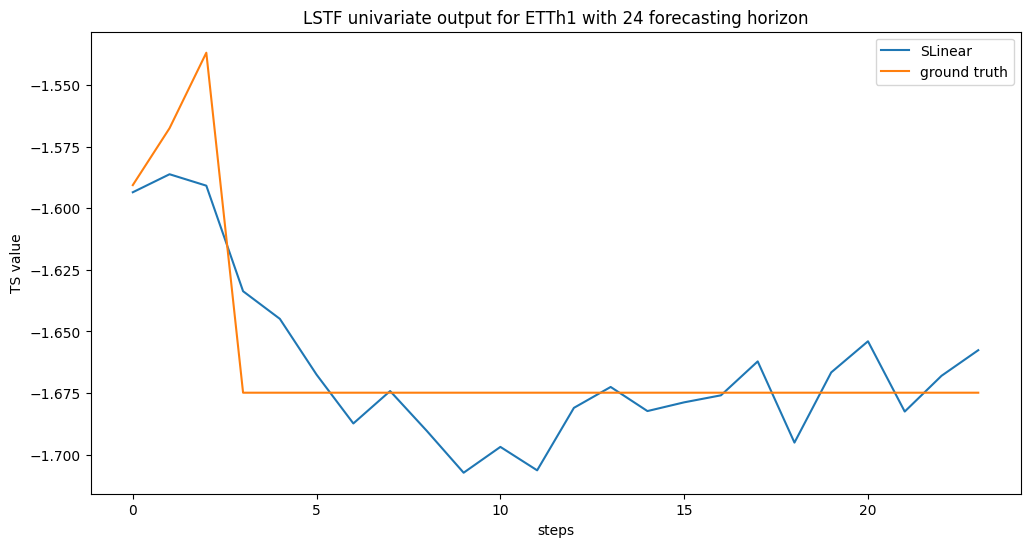

INFO:APP:current pred_len: 48


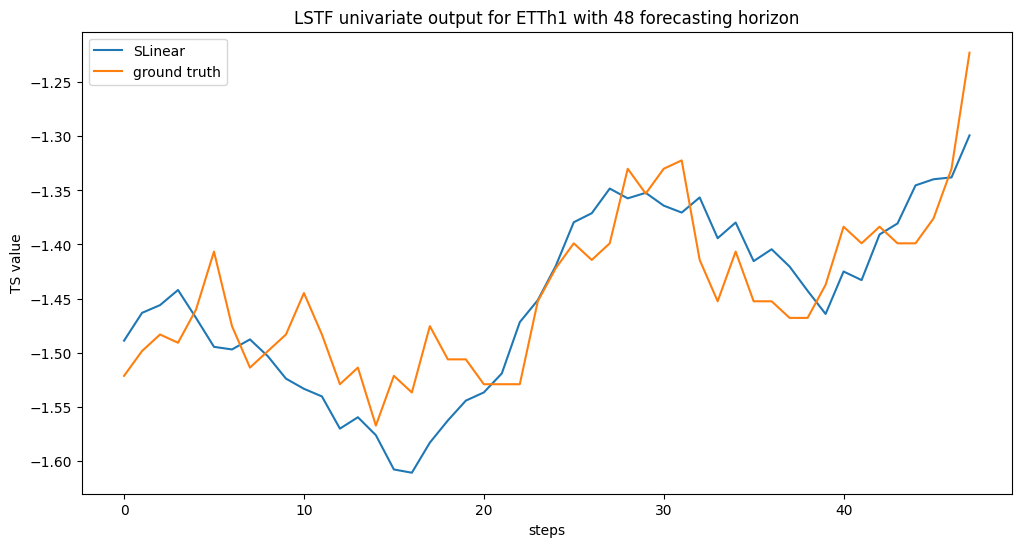

INFO:APP:current pred_len: 168


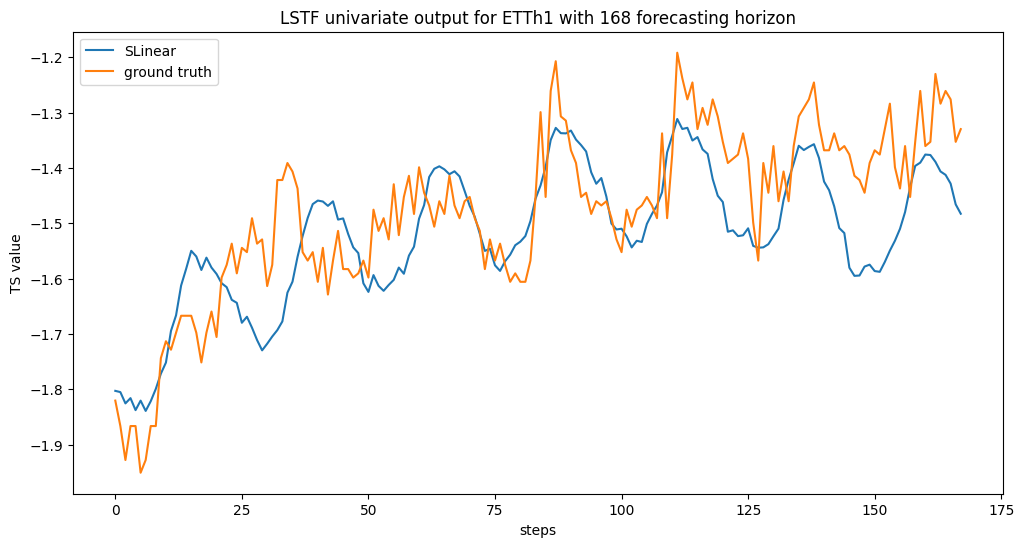

INFO:APP:current pred_len: 336


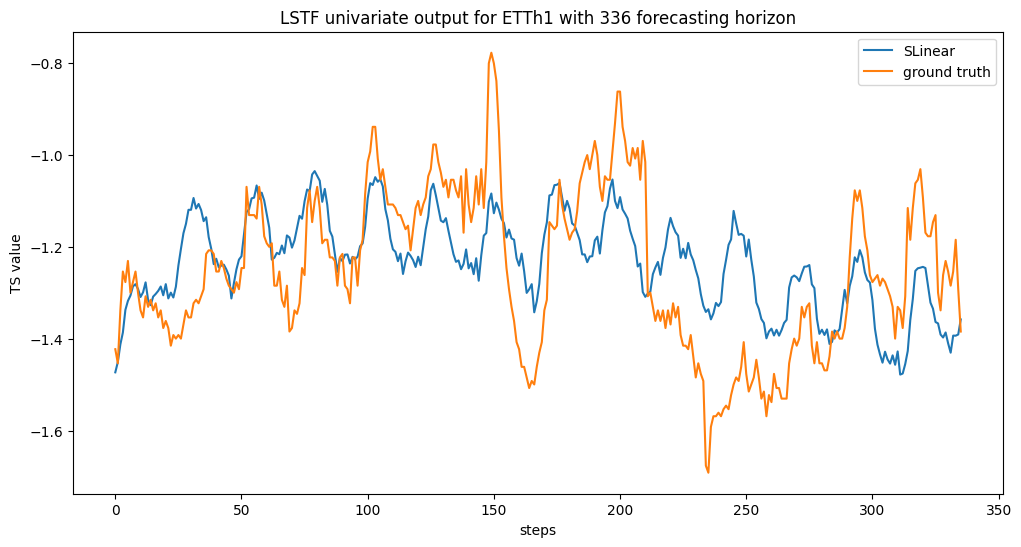

INFO:APP:current pred_len: 720


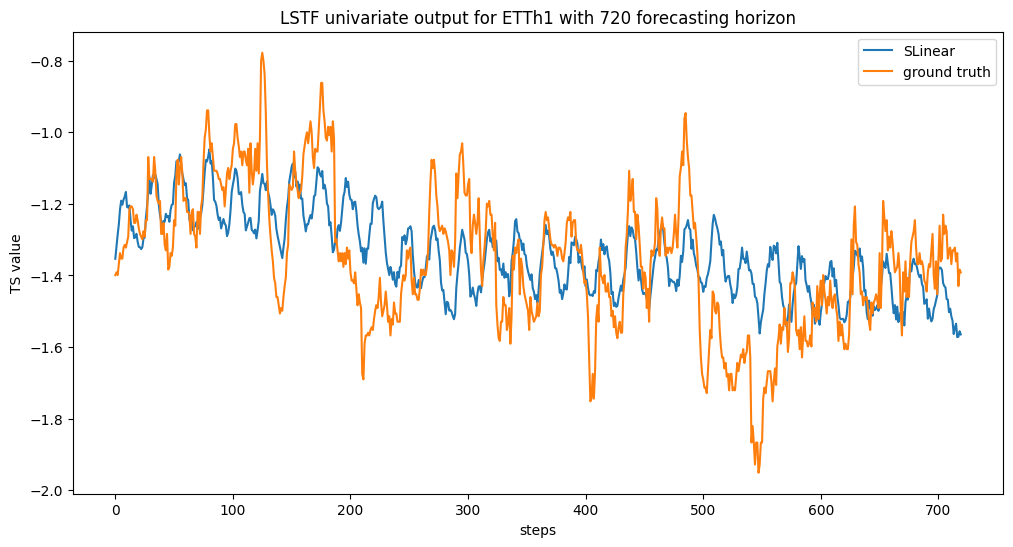

In [121]:
if PREDICT:
    log.info(f"best_batch_idx: {best_batch_idx}")
    for i,pred_len in enumerate(pred_lens):
        log.info(f"current pred_len: {pred_len}")
        plt.figure(figsize=(12,6))
        plt.plot(global_predictions[i], label = MODEL)
        plt.plot(global_true_values[i], label = "ground truth")
        plt.xlabel("steps")
        plt.ylabel("TS value")
        plt.title(f"LSTF univariate output for {DATASET} with {pred_len} forecasting horizon")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Tesi/thesis/plots/{MODEL}/plot_{MODEL}_{pred_len}.png")
        plt.close()